In [23]:
# MIS cost function is -sum_i x_i + 2*sum_ij x_i x_j

from pulser.devices import MockDevice
from pulser import Sequence, Register
from pulser_simulation import QutipEmulator
from skopt import gp_minimize
from pulser import Pulse

def one_layer(time_1, time_2, omega, delta):
    pulse_1 = Pulse.ConstantPulse(
        duration=time_1,
        amplitude=omega,
        detuning=0,
        phase=0
    )

    pulse_2 = Pulse.ConstantPulse(
        duration=time_2,
        amplitude=0,
        detuning=delta,
        phase=0
    )

    return pulse_1, pulse_2

def MIS_cost(bitstring, E):
    cost = 0
    # linear part of cost function
    for b in bitstring:
        if b=="1":
            cost -= 1
    # quadratic part of cost function
    for (i,j) in E:
        if (bitstring[i]=="1") and (bitstring[j]=="1"):
            cost += 2
    return cost

def MIS_cost_samples(samples, E):
    total_cost = 0
    for bitstring, count in samples.items():
        total_cost += MIS_cost(bitstring, E) * count
    return total_cost / sum(samples.values())

# params = [t1, t2, t3, t4, ....]

def minimization(qubits, E, n_layers):
    
    def score(params):
        reg = Register(qubits)
        seq = Sequence(reg, MockDevice)
        seq.declare_channel("ch", "rydberg_global")
        omega = 10
        delta = 4
        for i in range(int(len(params)/2)):
            p1, p2 = one_layer(params[2*i], params[2*i+1], omega, delta)
            seq.add(p1, "ch")
            seq.add(p2, "ch")
        sim = QutipEmulator.from_sequence(seq)
        samples = sim.run().sample_final_state(10000)
        
        return MIS_cost_samples(samples, E)
    
    optimization = gp_minimize(
        func=score,
        dimensions=[(100, 500)]*n_layers, #(lower_bound, upper_bound)
        n_calls=20,
    )

    return optimization

In [24]:
qubits = {
    "q1": [0,0],
    "q2": [5, 0],
    "q3": [3, -2],
    "q4": [-3, -1]
}

E = [(0,1), (0,2), (2,3)]

results = minimization(qubits, E, 6)

In [25]:
results.x

[np.int64(185),
 np.int64(108),
 np.int64(309),
 np.int64(479),
 np.int64(369),
 np.int64(301)]

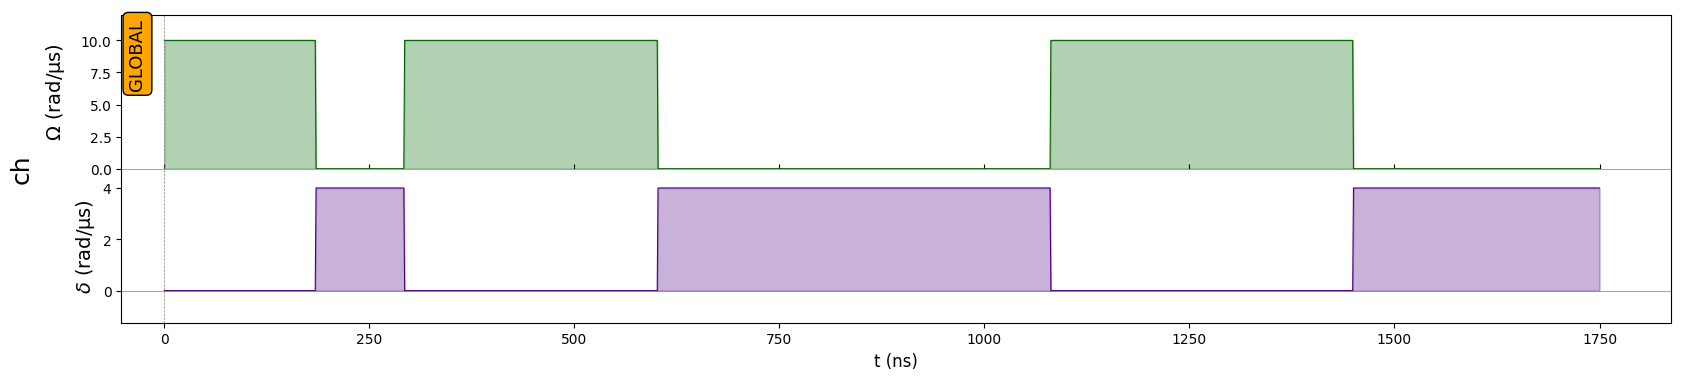

In [28]:
reg = Register(qubits)
seq = Sequence(reg, MockDevice)
seq.declare_channel("ch", "rydberg_global")
omega = 10
delta = 4
params = results.x
for i in range(int(len(params)/2)):
    p1, p2 = one_layer(params[2*i], params[2*i+1], omega, delta)
    seq.add(p1, "ch")
    seq.add(p2, "ch")
seq.draw()
sim = QutipEmulator.from_sequence(seq)
samples = sim.run().sample_final_state(10000)

In [ ]:
E = [(0,1), (0,2), (2,3)]
samples

Counter({'0101': 4104,
         '0010': 1544,
         '1000': 1531,
         '0000': 1309,
         '0001': 758,
         '0100': 730,
         '0011': 17,
         '1100': 7})